In [1]:
################################################################################
#                                                                              #
#                         Author: Bc. Petr Pouč                                #
#                         Date: April 4, 2024                                  #
#                         School: Brno University of Technology (BUT)          #
#                                                                              #
#         Master's Thesis: Optimization of Classification Models               #
#                         for Malicious Domain Detection                       #
#                                                                              #
################################################################################

# Standard library imports
import copy

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
import torch 

# Local application/library specific imports
import sys
sys.path.append('..')  
from FETA_code.transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
from utils.preprocess_one_domain import NDF2

# Combined approach

In [3]:
from imblearn.over_sampling import SMOTE

input_data = {
    'benign': '../floor/benign_2307.parquet',
    'malign': '../floor/phishing_2307.parquet'
}
dataset = NDF2("cnn", True, input_data=input_data, one_line_processing=False)

# Assuming dataset['features'] and dataset['labels'] are already tensors
X = dataset['features'].numpy()  # Convert tensors to numpy arrays if possible
y = dataset['labels'].numpy()

# Convert numpy arrays to DataFrames to use scikit-learn tools for preprocessing
X_df = pd.DataFrame(X)
y_df = pd.Series(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

2024-05-10 10:33:28,947 - utils.preprocess_one_domain - INFO - Benign dataset path: ../floor/benign_2307.parquet
2024-05-10 10:33:28,955 - utils.preprocess_one_domain - INFO - Malign dataset path: ../floor/phishing_2307.parquet


Malign dataset path: ../floor/phishing_2307.parquet
Benign dataset path: ../floor/benign_2307.parquet


2024-05-10 10:33:29,525 - utils.preprocess_one_domain - INFO - Number of records in benign dataset: 432572
2024-05-10 10:33:29,527 - utils.preprocess_one_domain - INFO - Number of records in malign dataset: 36993
2024-05-10 10:33:30,072 - utils.preprocess_one_domain - INFO - Total percentage of missing values in benign dataset: 0.42%
2024-05-10 10:33:30,075 - utils.preprocess_one_domain - INFO - Total percentage of missing values in malign dataset: 0.52%


Before sampling: (469565, 180)


2024-05-10 10:33:41,794 - utils.preprocess_one_domain - INFO - Decision tree model saved to trained_borders/decision_tree_model.joblib
2024-05-10 10:33:42,076 - utils.preprocess_one_domain - INFO - New feature 'dtree_prob' created from decision tree predictions.
2024-05-10 10:33:42,883 - utils.preprocess_one_domain - INFO - Decision Tree Train Accuracy: 0.95
2024-05-10 10:33:42,885 - utils.preprocess_one_domain - INFO - Decision Tree Test Accuracy: 0.95
2024-05-10 10:33:53,963 - utils.preprocess_one_domain - INFO - Decision Tree Cross-Validation Scores: [0.95007731 0.95039675 0.9504731 ]
2024-05-10 10:33:53,978 - utils.preprocess_one_domain - INFO - Generated class map: {'benign_2307:unknown': 0, 'misp_2307:phishing': 1}
2024-05-10 10:34:06,612 - utils.preprocess_one_domain - INFO - Outliers thresholds saved to trained_borders/outliers.joblib
2024-05-10 10:34:07,065 - utils.preprocess_one_domain - INFO - Outliers removed from dns_A_count: 520 rows
2024-05-10 10:34:07,262 - utils.prepro


Dataset Subset:
Name: dataset_../floor/benign2307_../floor/phishing2307_2024-05-10.parquet
Features:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   0.731059   0.535654   0.555328    0.50000   0.500000   0.500000   
1   0.500000   0.517850   0.500000    0.50000   0.500000   0.500000   
2   0.500000   0.517850   0.555328    0.50000   0.500000   0.500000   
3   0.500000   0.500000   0.500000    0.50000   0.500000   0.500000   
4   0.500000   0.517850   0.500000    0.54533   0.576322   0.681354   
5   0.500000   0.517850   0.500000    0.50000   0.500000   0.500000   
6   0.500000   0.500000   0.500000    0.50000   0.576322   0.500000   
7   0.500000   0.500000   0.500000    0.50000   0.500000   0.500000   
8   0.500000   0.500000   0.500000    0.50000   0.500000   0.500000   
9   0.500000   0.500000   0.500000    0.50000   0.500000   0.500000   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_169  Feature_170  \
0   0.500000   0.500000   0.500000  

# SVM model, params defined from tuning process

In [5]:
svm_x_train = copy.deepcopy(X_train)
svm_x_test = copy.deepcopy(X_test)
svm_y_train = copy.deepcopy(y_train)
svm_y_test = copy.deepcopy(y_test)

# Function to handle non-numeric data
# def handle_non_numeric_data(df):
#     le = LabelEncoder()
#     for column in df.columns:
#         if df[column].dtype == object:
#             df[column] = le.fit_transform(df[column].astype(str))
#     return df

# # Apply the function to both train and test dataframes
# svm_x_train = handle_non_numeric_data(svm_x_train)
# svm_x_test = handle_non_numeric_data(svm_x_test)

# Subsample the training data
svm_x_train, _, svm_y_train, _ = train_test_split(
    svm_x_train, svm_y_train, test_size=0.2, random_state=42, shuffle=True, stratify=svm_y_train
)

print(f"After Subsampling - svm_x_train: {len(svm_x_train)}, svm_y_train: {len(svm_y_train)}")

# Fill NaNs with zero (to ensure there are no NaNs after encoding)
svm_x_train.fillna(0, inplace=True)
svm_x_test.fillna(0, inplace=True)
svm_y_train.fillna(0, inplace=True)
svm_y_test.fillna(0, inplace=True)

# Convert to numpy arrays
svm_x_train = np.array(svm_x_train)
svm_x_test = np.array(svm_x_test)
svm_y_train = np.array(svm_y_train)
svm_y_test = np.array(svm_y_test)

# Convert logical values False and True to 0 and 1
svm_x_train = np.where(svm_x_train == False, 0, np.where(svm_x_train == True, 1, svm_x_train))
svm_x_test = np.where(svm_x_test == False, 0, np.where(svm_x_test == True, 1, svm_x_test))

# Scaling
scaler = MinMaxScaler()
svm_x_train = scaler.fit_transform(svm_x_train)
svm_x_test = scaler.transform(svm_x_test)

# Define SVM model parameters and train
params = {
    "C": 59,
    "gamma": 0.1,
    "kernel": "rbf",
    "random_state": 42,
    "class_weight": "balanced"
}
model = SVC(**params, verbose=True)
model.fit(svm_x_train, svm_y_train)

After Subsampling - svm_x_train: 27630, svm_y_train: 27630
[LibSVM]

...........*.....*
optimization finished, #iter = 16006
obj = -10465.877449, rho = -1.337100
nSV = 1430, nBSV = 77
Total nSV = 1430


SVC(C=59, gamma=0.1, random_state=42, verbose=True)

True Negatives (TN): 8020
False Positives (FP): 53
False Negatives (FN): 54
True Positives (TP): 508

False Positive Rate (FPR): 0.006565093521615261
True Positive Rate (TPR): 0.9039145907473309 (also known as Recall)

F1 Score: 0.9047

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9933    0.9934    0.9934      8073
         1.0     0.9055    0.9039    0.9047       562

    accuracy                         0.9876      8635
   macro avg     0.9494    0.9487    0.9490      8635
weighted avg     0.9876    0.9876    0.9876      8635



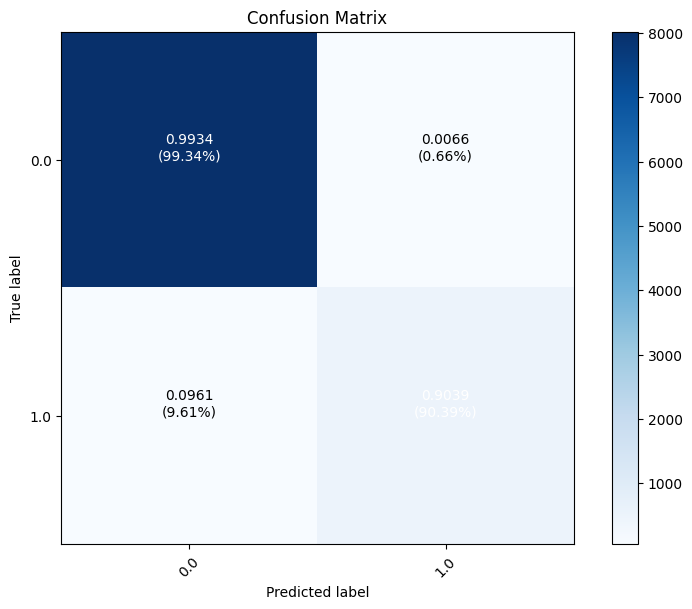

In [6]:
class ModelValidator:
    """
    A class for validating machine learning models with various metrics.

    Attributes:
        model (estimator): The machine learning model to be validated.
        X_test (array-like): The test dataset features.
        y_test (array-like): The true labels corresponding to X_test.
    """

    def __init__(self, model, X_test, y_test):
        """
        The constructor for ModelValidator class.

        Parameters:
           model (estimator): The trained machine learning model.
           X_test (array-like): Features from the test dataset.
           y_test (array-like): True labels for the test dataset.
        """
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate_performance(self):
        """
        Evaluates and prints the model's performance metrics.
        """
        y_pred = self.model.predict(self.X_test)
        f1 = f1_score(self.y_test, y_pred)
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        # Calculating False Positive Rate (FPR) and True Positive Rate (TPR)
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0

        # Displaying basic metrics
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Positives (TP): {tp}\n")
        print(f"False Positive Rate (FPR): {fpr}")
        print(f"True Positive Rate (TPR): {tpr} (also known as Recall)\n")
        print(f"F1 Score: {f1:.4f}\n")

        # Display classification report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred, digits=4))

        # Plotting the confusion matrix
        self.plot_confusion_matrix(y_pred)

    def plot_confusion_matrix(self, y_pred):
        """
        Plots the confusion matrix of the model's predictions with enhanced visual detail.

        Parameters:
           y_pred (array-like): Predicted labels for the test dataset.
        """
        cm = confusion_matrix(self.y_test, y_pred, labels=self.model.classes_)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(self.model.classes_))
        plt.xticks(tick_marks, self.model.classes_, rotation=45)
        plt.yticks(tick_marks, self.model.classes_)

        # Normalize the confusion matrix.
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Annotating the confusion matrix with text
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, f"{cm[i, j]:.4f}\n({cm[i, j]*100:.2f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

# Example usage
validator = ModelValidator(model, svm_x_test, svm_y_test)
validator.evaluate_performance()